In [1]:
import scipy.io
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR

In [2]:
data = scipy.io.loadmat("../data/ex3data1.mat")
raw_X = data['X']
raw_y = data['y']
raw_y[raw_y == 10] = 0

In [3]:
x_train, x_test, y_train, y_test = train_test_split(raw_X, raw_y, test_size=0.2, random_state=42)

x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.int64).flatten()
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.int64).flatten()

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"{X.shape}")
    print(f"{y.shape} {y.dtype}")
    break

torch.Size([64, 400])
torch.Size([64]) torch.int64


In [4]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(20*20, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 10)
        )

        # 使用 Xavier 初始化权重
        for layer in self.linear_relu_stack:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_normal_(layer.weight, gain=1.414)
                nn.init.zeros_(layer.bias)

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=400, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [5]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=10, gamma=0.9)

In [6]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if batch % 20 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            # print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    scheduler.step()

In [7]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    return f"Test Error: \n  Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n"

In [8]:
epochs = 100
for epoch in range(epochs):
    train(train_dataloader, model, loss_fn, optimizer)
    str_info = test(test_dataloader, model, loss_fn)
    if (epoch + 1) % 20 == 0:
        print(f"Epoch {(epoch + 1)} \n-------------------------------")
        print(str_info)
print("Done!")

Epoch 20 
-------------------------------
Test Error: 
  Accuracy: 74.9%, Avg loss: 1.373604 

Epoch 40 
-------------------------------
Test Error: 
  Accuracy: 81.2%, Avg loss: 0.994641 

Epoch 60 
-------------------------------
Test Error: 
  Accuracy: 83.5%, Avg loss: 0.811205 

Epoch 80 
-------------------------------
Test Error: 
  Accuracy: 84.5%, Avg loss: 0.711227 

Epoch 100 
-------------------------------
Test Error: 
  Accuracy: 84.9%, Avg loss: 0.652351 

Done!


Predicted: "1", Actual: "1"


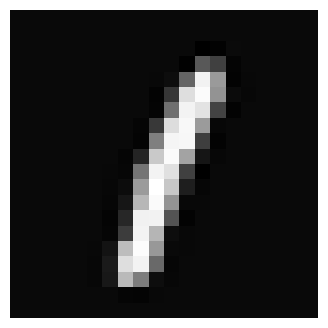

In [9]:
import matplotlib.pyplot as plt

model.eval()
random_idx = torch.randint(len(x_train_tensor), (1,)).item()

x, y = x_train_tensor[random_idx], y_train_tensor[random_idx]

with torch.no_grad():
    x = x.to(device)
    x = x.reshape(1, -1)
    pred = model(x)
    predicted, actual = pred[0].argmax(0), y
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

x_image = x.cpu().numpy().squeeze()
x_image = x_image.reshape(20, 20)
plt.figure(figsize=(4, 4))
plt.imshow(x_image.transpose(), cmap='gray')
plt.axis('off')
plt.show()